# Import libraries

In [34]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from scoring_functions import process_api_functions as api_func, scoring_functions as f

# imp allows to reload the above function files when tinkering with it without kernel restart
import imp

# Get data from API and process

Function is `api_func.download_and_process_api_data(date, size)`.  
- Date needs to be formatted as 'YYYY-MM-DD' string -- '2021-03-02' -- and function will get data from that date forward.  
- API allows max size of 1000 per call.   
- Function will remove stopwords from narrative, lemmatize, etc. and turn into dataframe in order to work with machine learning models previously used.   


## Testing

In [12]:
imp.reload(api_func)
api_func.download_and_process_api_data('2021-03-02', 50)

,product,narrative
0,0,determined creditor listed credit report belon...
1,0,initially bought great gear love thought paid ...
2,0,sent letter plus dispute keep putting address ...
3,4,well fargo failed provide outstanding relief a...
4,0,department education showing account open past...
5,0,well fargo continuously report late payment ac...
6,4,bank account open knowledge opening fraudulent...
7,0,signed paypal credit given line credit worth t...
8,2,cfpb filing official complaint regarding mortg...
9,0,account paid sent keep reporting owe called ge...


## Get data to use for modeling

In [13]:
api_df = api_func.download_and_process_api_data('2021-03-05', 1000)

In [14]:
len(api_df)

1000

In [15]:
api_df.tail()

,product,narrative
995,2,year row money taken escrow account paid hazar...
996,0,scam continues credit inquiry consumer shop ma...
997,0,loan disbursed amount department education ina...
998,3,care credit bank scamming customer like many o...
999,0,keep financial situation small spot fraudulent...


# Run Naive Bayes model with API data

## Load primary data

In [17]:
# read datafile
df = pd.read_csv('../project_data/complaints_processed.csv')

# clean up by removing NaN's, etc.
df.drop(['Unnamed: 0'], axis=1, inplace=True)

df = df.dropna()
df.drop(df.loc[df['narrative'] == 'name'].index, inplace=True)

# replace class names with integers
product_dict ={'credit_reporting': 0, 'debt_collection': 1, 'mortgages_and_loans': 2, 
               'credit_card': 3, 'retail_banking': 4}
df['product'].replace(product_dict, inplace=True)

In [18]:
df.head()

,product,narrative
0,3,purchase order day shipping amount receive pro...
1,3,forwarded message date tue subject please inve...
2,4,forwarded message cc sent friday pdt subject f...
3,0,payment history missing credit report speciali...
4,0,payment history missing credit report made mis...


## Divide data into narratives and targets

In [19]:
main_X = df['narrative']
main_y = df['product']

In [22]:
api_X = api_df['narrative']
api_y = api_df['product']

## Vectorize data and run and score models

In [26]:
# Vectorize X train and test data
vectorizer_nb = CountVectorizer(ngram_range=(1,2), max_features=70000)
vect_X_main = vectorizer_nb.fit_transform(main_X)
vect_X_api = vectorizer_nb.transform(api_X)
feature_names = vectorizer_nb.get_feature_names()

In [27]:
# Instantiate model
nb_model = MultinomialNB(alpha=0.45)

TRAINING - Classification Report
Accuracy: 82.5%
Precision: 76.2%
Recall: 85.3%
F1: 79.9%
              precision    recall  f1-score   support

           0       0.96      0.80      0.87     91171
           1       0.71      0.79      0.75     23145
           2       0.70      0.91      0.79     18990
           3       0.63      0.84      0.72     15564
           4       0.80      0.93      0.86     13535

    accuracy                           0.83    162405
   macro avg       0.76      0.85      0.80    162405
weighted avg       0.85      0.83      0.83    162405

TESTING - Classification Report
Accuracy: 80.6%
Precision: 74.3%
Recall: 83.0%
F1: 77.7%
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       558
           1       0.69      0.79      0.74       165
           2       0.70      0.96      0.81       105
           3       0.56      0.76      0.64        78
           4       0.83      0.86      0.84        94

    ac

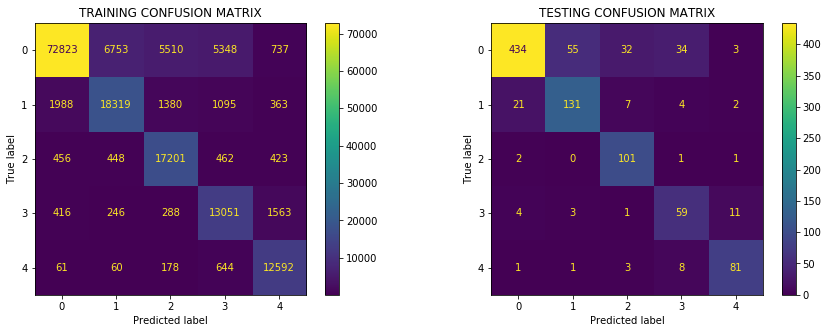

In [29]:
f.run_model(nb_model, vect_X_main, main_y, vect_X_api, api_y)

# Run Gradient Boosting with API data

## Vectorize data and run and score models

In [32]:
vectorizer_gb = TfidfVectorizer(max_features=16000)
vect_X_main = vectorizer_gb.fit_transform(main_X)
vect_X_api = vectorizer_gb.transform(api_X)
feature_names = vectorizer_gb.get_feature_names()

In [35]:
# Instantiate model
gb_model = GradientBoostingClassifier(random_state=123, max_depth=5)

TRAINING - Classification Report
Accuracy: 87.7%
Precision: 86.1%
Recall: 82.7%
F1: 84.3%
              precision    recall  f1-score   support

           0       0.89      0.94      0.92     91171
           1       0.82      0.73      0.77     23145
           2       0.88      0.82      0.85     18990
           3       0.83      0.78      0.80     15564
           4       0.88      0.87      0.88     13535

    accuracy                           0.88    162405
   macro avg       0.86      0.83      0.84    162405
weighted avg       0.87      0.88      0.87    162405

TESTING - Classification Report
Accuracy: 85.6%
Precision: 83.9%
Recall: 81.8%
F1: 82.8%
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       558
           1       0.77      0.78      0.78       165
           2       0.88      0.85      0.86       105
           3       0.74      0.73      0.74        78
           4       0.92      0.83      0.87        94

    ac

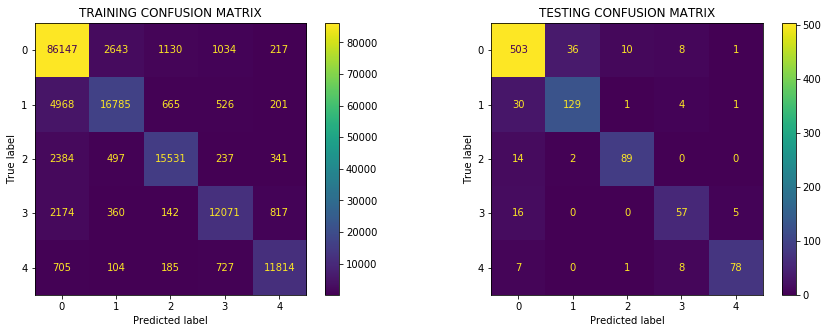

In [36]:
f.run_model(gb_model, vect_X_main, main_y, vect_X_api, api_y)

Fitting the models with the entire original dataset and checking the model against the API data, it finds:  
- The Naive Bayes model has a slightly better recall macro score than the Gradient Boosting Classifier -- .85 vs. .83  
- The GB has a little less of an overfitting issue, a difference of .01 between the two macro recall scores compared to a difference of .02 for NB's scores.
- Although the averages are similar, the NB class scores are generally more consistent while the GB does quite well in some classes (.94 recall for class 0) and worse in others (0.73 recall in class 1).  
- The NB model is a LOT faster, 5 seconds vs. 57 minutes.  

## Get feature importances

It's easy to get feature importances from the GB model, while the NB doesn't have an intrinsic method.

In [37]:
 gb_model.fit(vect_X_main, main_y)

GradientBoostingClassifier(max_depth=5, random_state=123)

In [38]:
gb_model.feature_importances_

array([0., 0., 0., ..., 0., 0., 0.])

In [41]:
vect_X_main.shape

(162405, 16000)

Zip the array of feature importances with the `feature_names` from TF-IDF.

In [55]:
feat_importa = zip(feature_names, gb_model.feature_importances_)

Turn the zip into a list

In [56]:
feature_importances_list = list(feat_importa)

Export to use in another notebook.

In [61]:
import pickle

with open('../project_data/feature_importances_list.txt', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(feature_importances_list, filehandle)